# Random topography generation using the Diamond-Square algorithm

## Vectorized Diamond-Square algorihm

From Wikipedia https://en.wikipedia.org/wiki/Diamond-square_algorithm:

The diamond-square algorithm begins with a 2D square array of width and height 2n + 1. The four corner points of the array must first be set to initial values. The diamond and square steps are then performed alternately until all array values have been set.

The diamond step: For each square in the array, set the midpoint of that square to be the average of the four corner points plus a random value.

The square step: For each diamond in the array, set the midpoint of that diamond to be the average of the four corner points plus a random value.

At each iteration, the magnitude of the random value should be reduced.

During the square steps, points located on the edges of the array will have only three adjacent values set rather than four. There are a number of ways to handle this complication - the simplest being to take the average of just the three adjacent values. Another option is to 'wrap around', taking the fourth value from the other side of the array. When used with consistent initial corner values this method also allows generated fractals to be stitched together without discontinuities.


![DS_algorithm](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Diamond_Square.svg/1600px-Diamond_Square.svg.png)

In [20]:
import sys
import importlib
import random
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, "../../../gempy2/")
import gempy.utils.diamond_square
importlib.reload(gempy.utils.diamond_square)

<module 'gempy.utils.diamond_square' from '../../../gempy2/gempy/utils/diamond_square.py'>

## Create a diamond-square object and visualize hierarchies

We first create a simple diamond-square object with a size of 9x9. This corresonds to three hierarchical levels `(2**n+1, 2**m+1)`.

In [21]:
ds = gempy.utils.diamond_square.DiaomondSquare(size=(9,9))

We can now visualize the cells that are selected for the diamond steps (top row) and square step (bottom row) for all relevant hierarchies. Try different grid sizes above to see the effect (e.g. `size=(17,17)` to obtain four hierarchical levels on a square, or `size=(9,18)` to get a rectangle instead of a square):

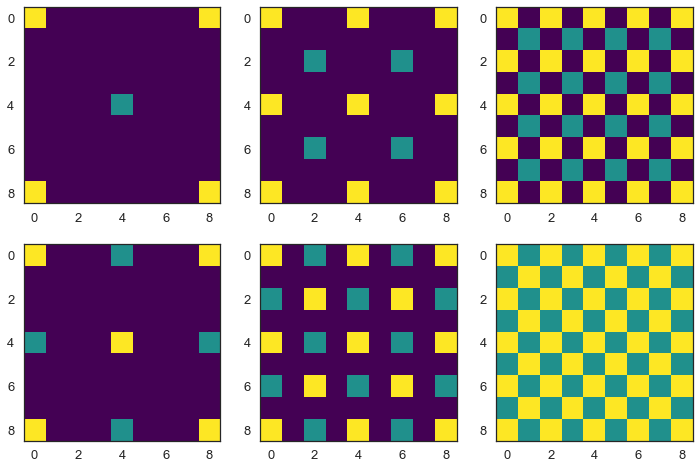

In [22]:
ds.plot_diamond_and_square(pad=False)

Just for completeness, the example from the wikipedia page (see figure above, here reproduced) is obtained with `size=(5,5)`:
![DS_algorithm](https://upload.wikimedia.org/wikipedia/commons/thumb/b/bf/Diamond_Square.svg/1600px-Diamond_Square.svg.png)

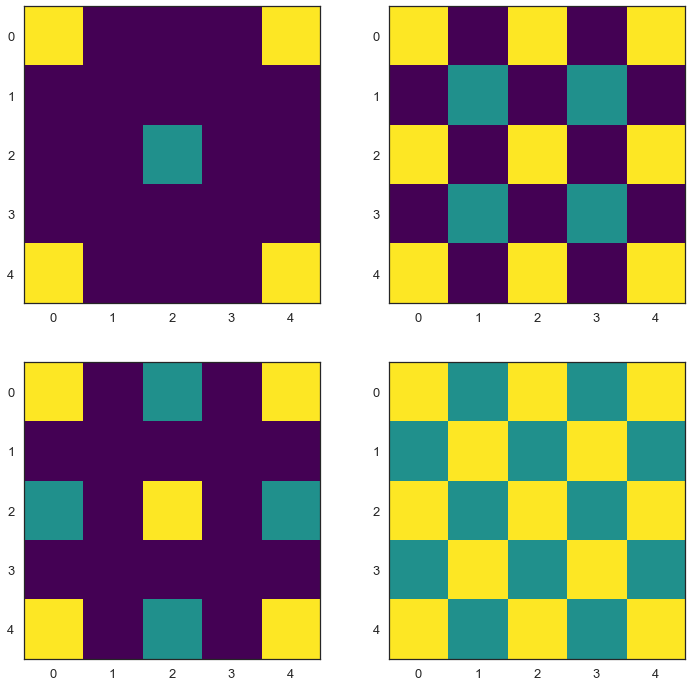

In [23]:
ds = gempy.utils.diamond_square.DiaomondSquare(size=(5,5))
ds.plot_diamond_and_square(pad=False)

## Generating artificial landscapes with the diamond-square algorithm

We can now perform the interpolation step using the diamond-square algorithm. In addition to the patterns described above, we need two additional aspects:

1. An initialization with values on grid points at a specified hierarchy level;
2. A randomization method.

For **step 1**, the "classical" approach is to randomly seed values at the edges of a square grid. This method can be extended to non-square grid, with appropriate consideration of internal cells.

In addition, it can also be reasonable to intialize values on a _lower_ hierarchy level. For example, in the case of a square 9x9 grid, we could initialize values on the highest hierarchy, i.e. the cornerpoints of the grid, but also on a 5x5 subgrid. When initializing then with independent random values, the lower-hierarchy initialization will lead to a more independent randomized sub-structure inside the grid.

Note that, in any case, the random initialization can be performed with specified or randomized values (or a combination of both).

For **step 2**, the randomization of the interpolated values, several options are available in the literature and other implementations of the algorithm. It is common practice to reduce the range of the random variable from higher to lower hierarchies, to obtain a more natural behaviour. We chose here the following implementation:

- we define an initial _roughness_ variable $\theta$
- the random variability is then calculated on the level of an iteration $i$, where the highest hierarchy corresponds to iteration 0. The randomization is obtained with a uniform distribution $\mathcal{U}(-0.5,0,5)$, which is appropriately scaled by an iteration-adjusted roughness factor using the equation:

$$\mathcal{U}(-0.5,0,5) \cdot \theta^i$$

We first compare interpolations in the "conventional" form, with seeds on the highest hierarchy level, and then look at examples with lower-hierarchy initializations. 

### Interpolation on highest hierarchy level

We will start with a comparison of models with different roughness values. In order to obtain reproducible results, we can set the random seed. If we do this here, we also obtain a fixed initialization, leading to comparable results for the effect of the roughness value:



In [44]:
importlib.reload(gempy.utils.diamond_square)

ds1 = gempy.utils.diamond_square.DiaomondSquare(size=(5,5), roughness=0.2, r_type='default') #, seed=14235)


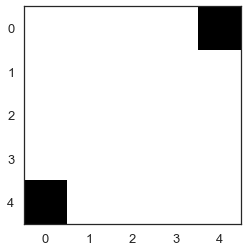

In [45]:
# ds1.random_initialization(level='highest')

ds1.grid[0,0] = 0.
ds1.grid[-1,0] = 1.
ds1.grid[0,-1] = 1.
ds1.grid[-1,-1] = 0.

plt.imshow(ds1.grid)

In [46]:
ds1.interpolate()

0.2
0.17411011265922482


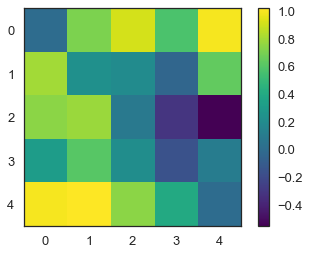

In [47]:
plt.imshow(ds1.grid, cmap='viridis')
plt.colorbar()

In [180]:
importlib.reload(gempy.utils.diamond_square)
ds = gempy.utils.diamond_square.DiaomondSquare(size=(65,129), roughness=.7, r_type='long_range', seed=520622)
ds.grid.shape

(65, 129)

In [181]:
level = 'highest'
ds.random_initialization(level = level)
ds.interpolate(level = level)

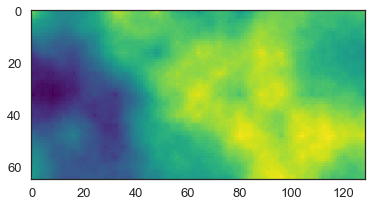

In [182]:
plt.imshow(ds.grid, cmap='viridis')

### Visualization in surface plot

Just to get a better impression of the general interpolation nature

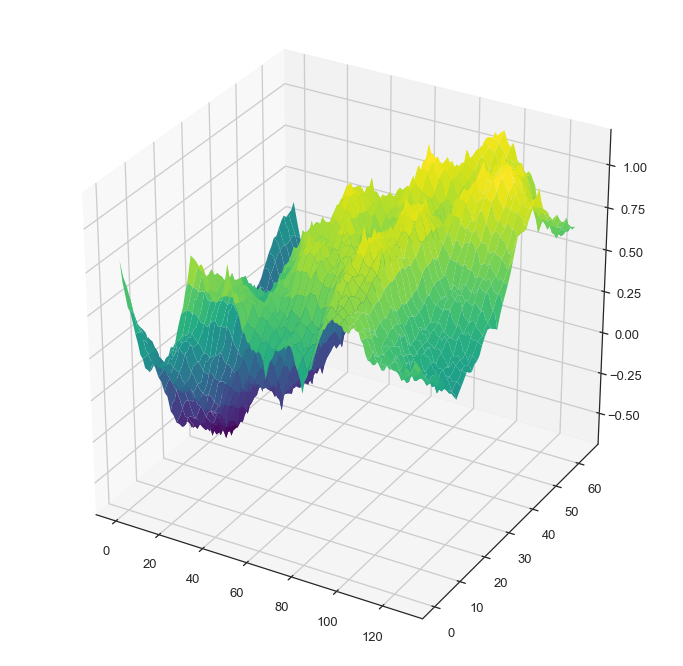

In [183]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import matplotlib.pyplot as plt


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(ds.grid.shape[1])
y = np.arange(ds.grid.shape[0])
X, Y = np.meshgrid(x,y)

# Plot a basic wireframe.
ax.plot_surface(X, Y, ds.grid, cmap=cm.viridis, linewidth=0)
plt.show()

### Additional smoothing

The surface is still quite spiky, even with the "long_range" interpolation method. This is, technically, not unrealistic - but depending on scale, a smoother behaviour may be desired. For this purpose, we can apply an additional gaussian filter (`scipy.ndimage.gaussian_filter`) step

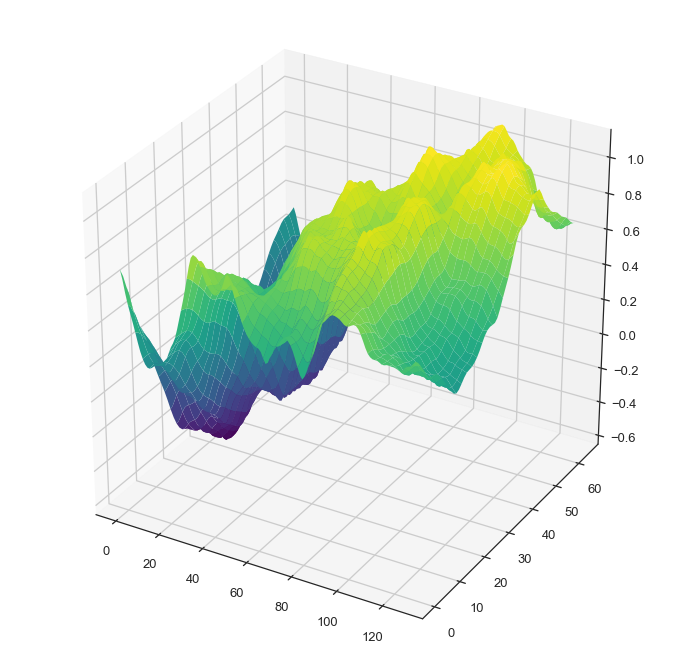

In [184]:
import scipy.ndimage as ndimage
Z_smooth = ndimage.gaussian_filter(ds.grid, 1)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x = np.arange(ds.grid.shape[1])
y = np.arange(ds.grid.shape[0])
X, Y = np.meshgrid(x,y)

# Plot a basic wireframe.
ax.plot_surface(X, Y, Z_smooth, cmap=cm.viridis, linewidth=0)
plt.show()

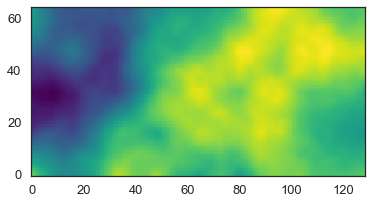

In [185]:
plt.imshow(Z_smooth, cmap='viridis', origin='lower left')

### Comparison of roughness values

Here now, finally, a comparison of multiple roughness values without and with an additional smoothing step:

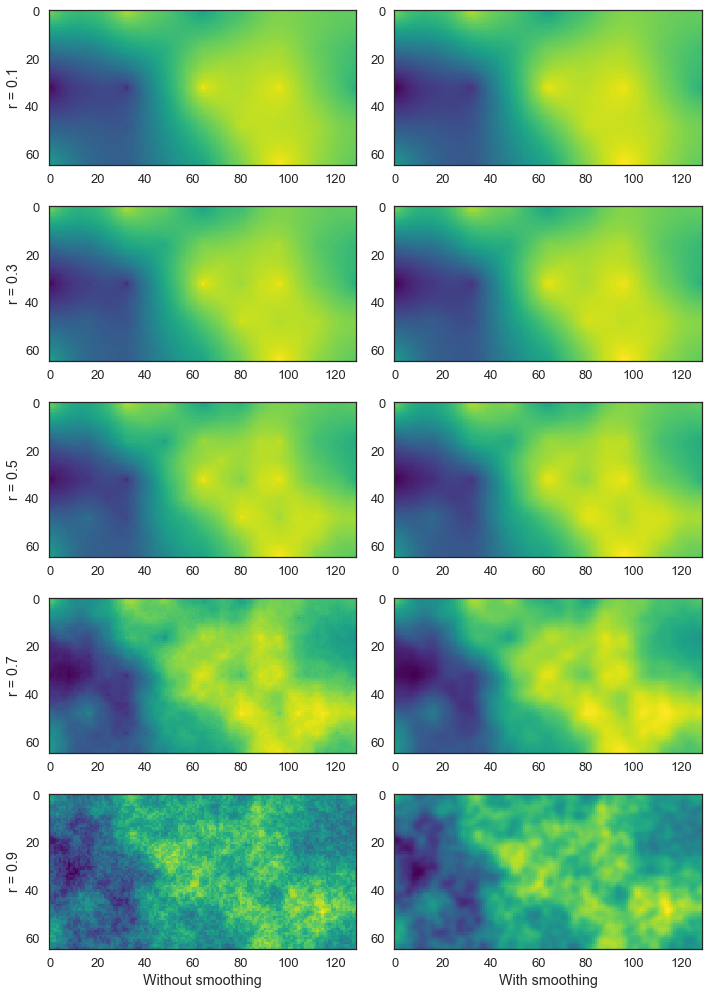

In [195]:
level = 'highest'

f, axes = plt.subplots(5,2, figsize=(10, 14))

for i, roughness in enumerate(np.arange(0.1,1.0,0.2)):
    ds = gempy.utils.diamond_square.DiaomondSquare(size=(65,129), roughness=roughness, 
                                                   r_type='long_range', seed=520622)
    ds.random_initialization(level = level)
    ds.interpolate(level = level)
    axes[i,0].imshow(ds.grid, cmap='viridis')
    axes[i,0].set_ylabel('r = %.1f' % roughness)
    if i==4:
        axes[i,0].set_xlabel("Without smoothing")
    # smooth
    Z_smooth = ndimage.gaussian_filter(ds.grid, 1)
    axes[i,1].imshow(Z_smooth, cmap='viridis')
    if i==4:
        axes[i,1].set_xlabel("With smoothing")
        
plt.tight_layout()
    
